<a href="https://colab.research.google.com/github/SophiaBieri/MLfEA-Project-1-Submission/blob/main/Ridge_%26_Lasso_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ridge Regression & Lasso Models**

## **Basic Approach**

### **Preparation**

We begin by importing the necessary libraries.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import matplotlib.lines as mlines
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures 
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import datasets
!pip install stargazer
from stargazer.stargazer import Stargazer
from keras.models import Sequential
from keras.layers import Dense
from sklearn.ensemble import RandomForestRegressor

In [27]:
# Set global parameters for figures
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

Next, we read in the dataset and save it in the data variable. We also take a look at its shape to confirm that everything was loaded correctly.

In [28]:
# Read in the data
data = pd.read_csv('data_preprocessed_full.csv')
# Get the shape of the data
data.shape

(45378, 70)

Then, we take a look at the head of the data.

In [29]:
# Set the display option to show all rows and all columns of the dataset
pd.options.display.max_rows = None
pd.options.display.max_columns = None
# Look at the head of the data
data.head()

,lnpercapitaconsumption,d_fuel_wood,d_fuel_coal,d_fuel_kerosene,d_fuel_gas,d_fuel_electric,d_fuel_none,d_water_river,d_water_well,d_water_truck,d_water_pylon,d_water_outside,d_water_inside,d_drain_none,d_drain_river,d_drain_cesspool,d_drain_septic,d_drain_outside,d_drain_inside,d_wall_woodmat,d_wall_stonemud,d_wall_quincha,d_wall_tapia,d_wall_adobe,d_wall_stonecement,d_wall_brickcement,d_roof_straw,d_roof_mat,d_roof_platecane,d_roof_tile,d_roof_wood,d_roof_concrete,d_floor_earth,d_floor_cement,d_floor_wood,d_floor_tile,d_floor_sheets,d_floor_parquet,d_electricity,d_telephone,d_h_educ_none,d_h_educ_pre,d_h_educ_prim,d_h_educ_sec,d_h_educ_higher_nouni,d_h_educ_higher_uni,d_h_educ_post,d_max_educ_none,d_max_educ_prim,d_max_educ_sec,d_max_educ_higher_nouni,d_max_educ_higher_uni,d_insurance_1,d_insurance_2,d_insurance_3,d_insurance_4plus,d_crowd_1to2,d_crowd_2to4,d_crowd_4to6,d_crowd_6plus,d_lux_1,d_lux_2,d_lux_3,d_lux_4,d_lux_5,training,id_for_matlab,hhid,lncaphat_OLS,percapitahat_OLS
0,5.351858,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,233710511,5.246471,284.4243
1,5.768755,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1,0,0,0,0,1,0,1.0,0.0,0.0,0.0,0,0,1,0,0,0,2,295508011,6.129468,522.8840
2,5.968277,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,1,0,0,0,1,0.0,0.0,0.0,0.0,0,0,1,0,0,0,3,257600211,6.665577,878.4961
3,5.654599,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0.0,1.0,0.0,0.0,0,0,0,0,0,0,4,198104311,6.088295,567.4705
4,4.771289,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,1,1.0,0.0,0.0,0.0,0,0,0,0,0,0,5,24805311,5.008170,115.4929


Next, we set per capita consumption as the dependent variable and rest of the columns (except the OLS predictions for *lnpercapitaconsumption* and *percapitaconsumtion*) as the explanatory variables.

In [30]:
# Get the data for the dependent variable
y_full = data['lnpercapitaconsumption']
# Get the data for the explanatory variables
X_full = data.drop(['training','id_for_matlab','hhid','lnpercapitaconsumption','lncaphat_OLS','percapitahat_OLS'], axis=1)

# Take a look at the shape of X_full
X_full.shape

(45378, 64)

In [31]:
# Split the data into training and test data
## Get test data
Xtest = X_full[data['training'] == 0]
ytest = y_full[data['training'] == 0]
## Get training data
X = X_full[data['training'] == 1]
y = y_full[data['training'] == 1]

Then we define a function to select the ideal hyper parameter lambda out of a predetermined grid of lambdas for either a Ridge or a Lasso regression (this can be chosen by setting *is_ridge* to True or False) by K-fold Cross validation.

The input variables are the following:

- *X_train*: the whole training data for the explanatory variables (either as pd.DataFrame of as np.ndarry)

- *y_train*: the whole training data for the dependent variable (either as pd.DataFrame of as np.ndarry)

- *K*: the number of folds to use in the K-fold cross validation

- *pow_min*: the power of the lower bound of the grid of lambdas to try

- *pow_max*: the power of the upper bound of the grid of lambdas to try

- nsteps: the number elements in the grid of lambdas (i.e. the number of equally large steps to increase the exponent of the chosen lambda from pow_min to pow_max)

Note: Hence, the grid of lambdas ranges from $10^{pow\_min}$ to $10^{pow\_max}$ where the exponent is increased by *nsteps* equally large steps.

In [32]:
# Suppress the convergence warnings which occur when a lasso is fitted
import warnings
warnings.filterwarnings("ignore")

# Define a function that returns the best lambda from a grid using K-fold cross validation on the training data
# Note that we only allow X_train and y_train to be either a pd.DataFrame or a np.ndarray.
def choose_hyper_param_by_Kfold_cv(X_train, y_train, K, pow_min, pow_max, nsteps, is_ridge: bool):
  # Check whether X_train and y_train are of type pd.DataFrame (or for y also pd.core.series.Series) and, if so, transform them into numpy arrays
  if(isinstance(X_train, pd.DataFrame)):
    X_train = X_train.to_numpy()
  if(isinstance(y_train, pd.DataFrame)):
    y_train = y_train.to_numpy()
  if(isinstance(y_train, pd.core.series.Series)):
    y_train = y_train.to_numpy()

  # Create variables to store the best lambda and the according mse
  mse_arr = []
  lam_arr = []
  # Set up a K-fold cross validation
  kf = KFold(n_splits = K)

  # Estimate K models for each lambda within the selected grid and choose the lambda that 
  # leads to the lowest average mse among the K models
  for pow_lam in np.linspace(pow_min, pow_max, num = nsteps, endpoint=True):
    lam = 10 ** pow_lam
    # Create a variable to store the mse of each K estimation
    mse_fold_arr = []

    # Estimate the model for all K splits
    for train_index, valid_index in kf.split(X_train):
      X_train_n = X_train[train_index]
      y_train_n = y_train[train_index]
      X_train_v = X_train[valid_index]
      y_train_v = y_train[valid_index]
      # Specify the model depending on the bool variable is_ridge
      if(is_ridge):
        model = Ridge(lam, fit_intercept=True, normalize=False).fit(X_train_n, y_train_n)
      else:
        model = Lasso(lam, fit_intercept=True, normalize=False).fit(X_train_n, y_train_n)
      # Get the predictions for the validation set
      y_pred = model.predict(X_train_v)
      # Calculate the mse
      mse = np.mean((y_pred - y_train_v) ** 2)
      # Stor the mse observed when using the hyperparameter lam for each hold out set
      mse_fold_arr.append(mse)

    # Get the average mse obtained when using hyperparameter lam
    mse_avg = np.mean(mse_fold_arr)
    # Add the average mse when using the hyperparameter lam
    mse_arr.append(mse_avg)
    lam_arr.append(lam)

  # Get the index of the lambda value that has the minimal average mse
  lambda_idx_min = np.argmin(np.array(mse_arr))

  # Report the best lambda and the associated MSE
  if(is_ridge):
    print('For a Ridge Regression we obtain that a lambda = %.2e leads to the lowest MSE = %.4f among the lambdas in the grid.' % (lam_arr[lambda_idx_min], mse_arr[lambda_idx_min]))
    title = "Ridge"
  else:
    print('For a Lasso we obtain that a lambda = %.2e leads to the lowest MSE = %.4f among the lambdas in the grid.' % (lam_arr[lambda_idx_min], mse_arr[lambda_idx_min]))
    title = "Lasso"
  # Plot the degrees of basis expansion versus their mse
  plt.figure()
  plt.semilogx(lam_arr, mse_arr)
  plt.title(title)
  plt.xlabel("Lambda")
  plt.ylabel("MSE")

  # return the best lambda value
  return lam_arr[lambda_idx_min]

Note that we include an intercept term and chose to not standardize the data. This can be done because all features are dummy variables and therefore measured on the same scale. Hence, the penalization of the estimated coefficients is not inappropriately different across features.

### **Optimal Lambda by 7-fold Cross Validation**

We start by running the above defined function for both, Ridge and Lasso Regression, using 7 fold cross validation and a chosing a comparatively wide and coarse grid of lambdas (from $10^{-15}$ to $10^{10}$ by $10$ steps) to get a first impression of where the optimal lambda might be located. Thereafter, we continue by narrowing and refining the grids step by step until we arrive at a sufficiently precise value for the optimal lambdas.

For a Ridge Regression we obtain that a lambda = 7.74e-02 leads to the lowest MSE = 0.1926 among the lambdas in the grid.


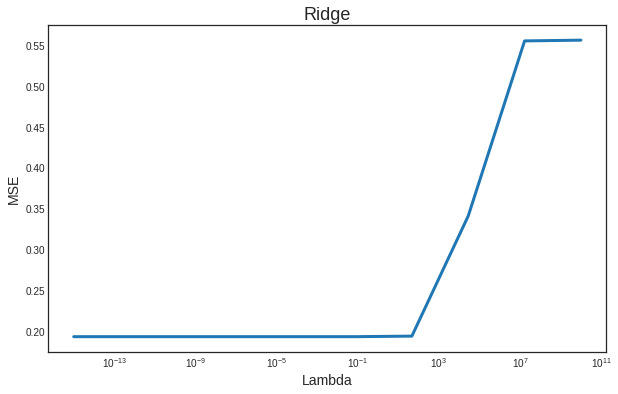

In [33]:
# Get the ideal lambda for the Ridge Regression
lam_ridge = choose_hyper_param_by_Kfold_cv(X, y, 7, -15, 10, 10, True)

For a Lasso we obtain that a lambda = 2.15e-07 leads to the lowest MSE = 0.1926 among the lambdas in the grid.


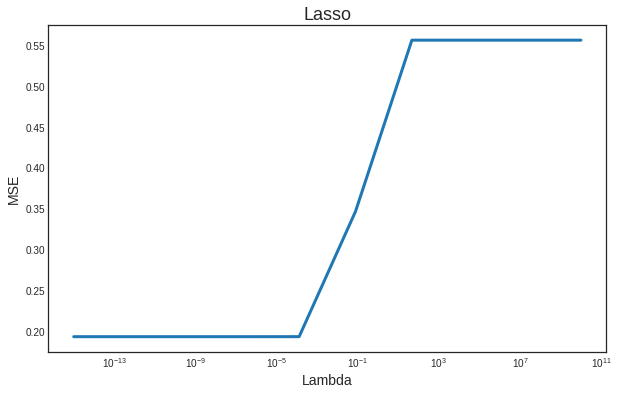

In [34]:
# Get the ideal lambda for the Lasso
lam_lasso = choose_hyper_param_by_Kfold_cv(X, y, 7, -15, 10, 10, False)

We observe that the optimal lambda for the Ridge regression seems to lie somewhere below $10^3$ while the one for the Lasso appears to be somewhere below $10^{-3}$. Hence, we repeat the above procedure using narrower grids of lambdas.



For a Ridge Regression we obtain that a lambda = 1.29e+00 leads to the lowest MSE = 0.1926 among the lambdas in the grid.


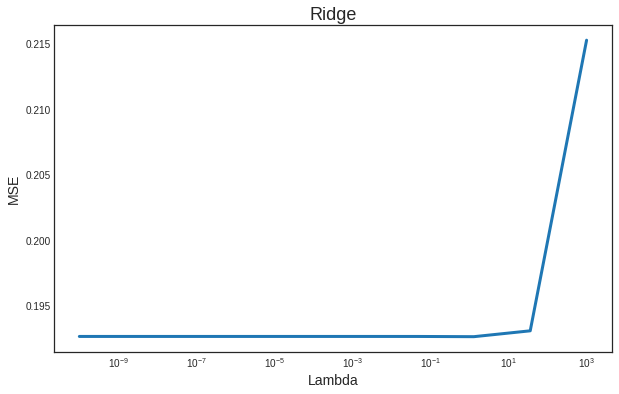

In [35]:
# Get the ideal lambda for the Ridge Regression
lam_ridge = choose_hyper_param_by_Kfold_cv(X, y, 7, -10, 3, 10, True)

For a Lasso we obtain that a lambda = 2.78e-05 leads to the lowest MSE = 0.1926 among the lambdas in the grid.


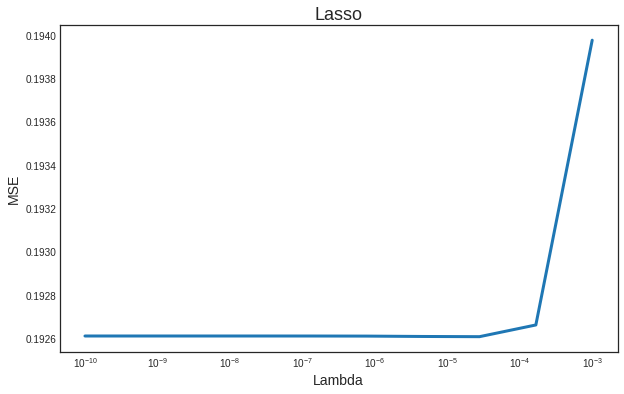

In [36]:
# Get the ideal lambda for the Lasso
lam_lasso = choose_hyper_param_by_Kfold_cv(X, y, 7, -10, -3, 10, False)

We observe that the optimal lambda for the Ridge regression seems to lie even below $10^2$ while the one for the Lasso appears to be somewhere below $10^{-3.9}$. Hence, we repeat the above procedure using a narrower grids of lambdas.

For a Ridge Regression we obtain that a lambda = 4.64e+00 leads to the lowest MSE = 0.1926 among the lambdas in the grid.


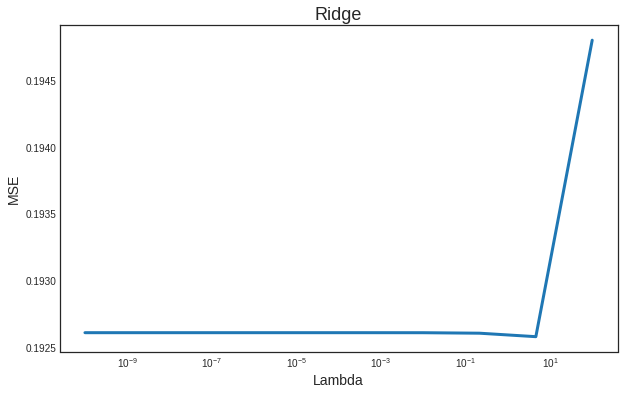

In [37]:
# Get the ideal lambda for the Ridge Regression
lam_ridge = choose_hyper_param_by_Kfold_cv(X, y, 7, -10, 2, 10, True)

For a Lasso we obtain that a lambda = 2.64e-05 leads to the lowest MSE = 0.1926 among the lambdas in the grid.


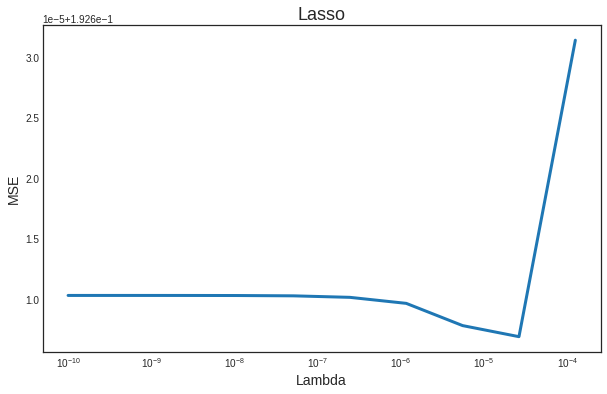

In [38]:
# Get the ideal lambda for the Lasso
lam_lasso = choose_hyper_param_by_Kfold_cv(X, y, 7, -10, -3.9, 10, False)

We observe that the optimal lambda for the Ridge regression seems to lie somewhere between $10^{-1}$ and $10$ while the one for the Lasso appears to be somewhere between $10^{-6}$ and $10^{-4}$. Hence, we further adjust the grids of lambdas and repeat the above procedure again.

For a Ridge Regression we obtain that a lambda = 3.59e+00 leads to the lowest MSE = 0.1926 among the lambdas in the grid.


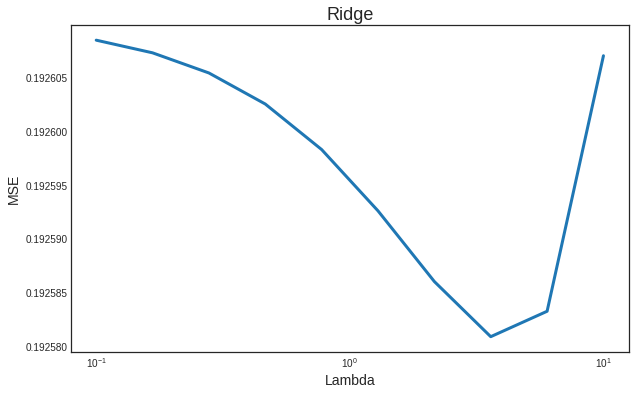

In [39]:
# Get the ideal lambda for the Ridge Regression
lam_ridge = choose_hyper_param_by_Kfold_cv(X, y, 7, -1, 1, 10, True)

For a Lasso we obtain that a lambda = 5.99e-05 leads to the lowest MSE = 0.1926 among the lambdas in the grid.


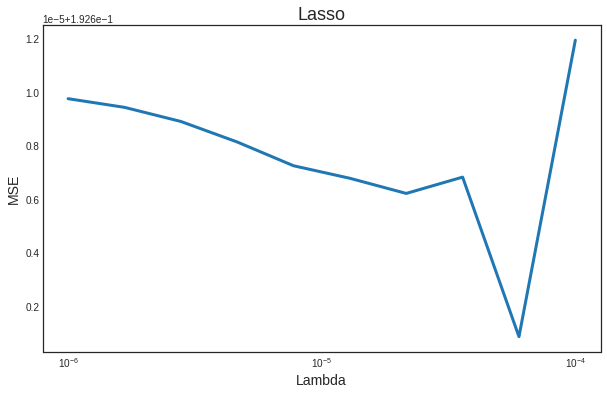

In [40]:
# Get the ideal lambda for the Lasso
lam_lasso = choose_hyper_param_by_Kfold_cv(X, y, 7, -6, -4, 10, False)

We observe that the optimal lambda for the Ridge regression seems to lie somewhere between $2$ and $6$ while the one for the Lasso appears to be somewhere between $0.00002$ and $0.00008$. Hence, we further adjust the grids of lambdas and repeat the above procedure again.

For a Ridge Regression we obtain that a lambda = 4.16e+00 leads to the lowest MSE = 0.1926 among the lambdas in the grid.


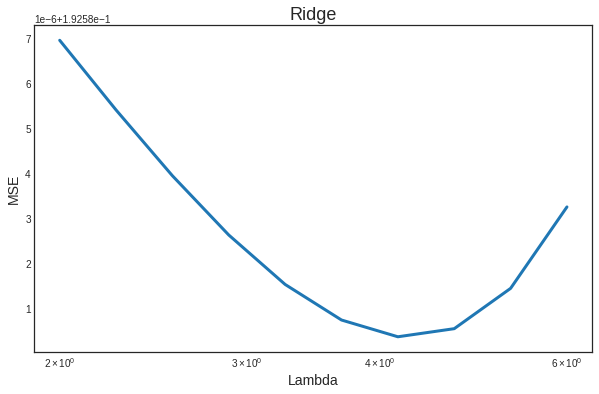

In [41]:
# Get the ideal lambda for the Ridge Regression
lam_ridge = choose_hyper_param_by_Kfold_cv(X, y, 7, np.log10(2), np.log10(6), 10, True)

For a Lasso we obtain that a lambda = 6.86e-05 leads to the lowest MSE = 0.1926 among the lambdas in the grid.


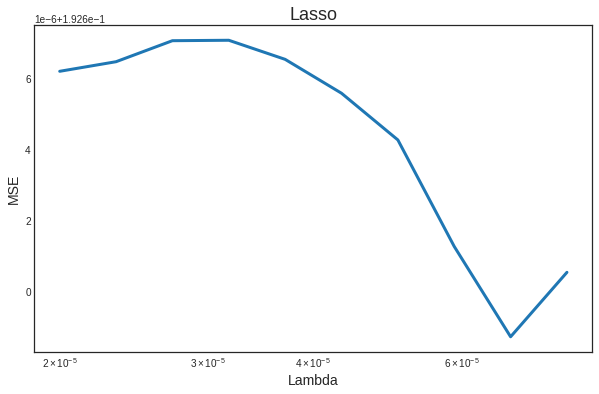

In [42]:
# Get the ideal lambda for the Lasso
lam_lasso = choose_hyper_param_by_Kfold_cv(X, y, 7, np.log10(0.00002), np.log10(0.00008), 10, False)

We observe that the optimal lambda for the Ridge regression seems to lie somewhere between $3.8$ and $4.8$ while the one for the Lasso appears to be somewhere between $0.00006$ and $0.00008$. Hence, we further adjust the grids of lambdas and repeat the above procedure again.

For a Ridge Regression we obtain that a lambda = 4.22e+00 leads to the lowest MSE = 0.1926 among the lambdas in the grid.


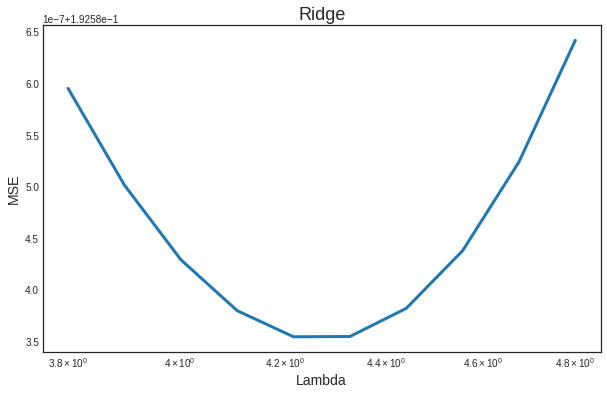

In [43]:
# Get the ideal lambda for the Ridge Regression
lam_ridge = choose_hyper_param_by_Kfold_cv(X, y, 7, np.log10(3.8), np.log10(4.8), 10, True)

For a Lasso we obtain that a lambda = 7.27e-05 leads to the lowest MSE = 0.1926 among the lambdas in the grid.


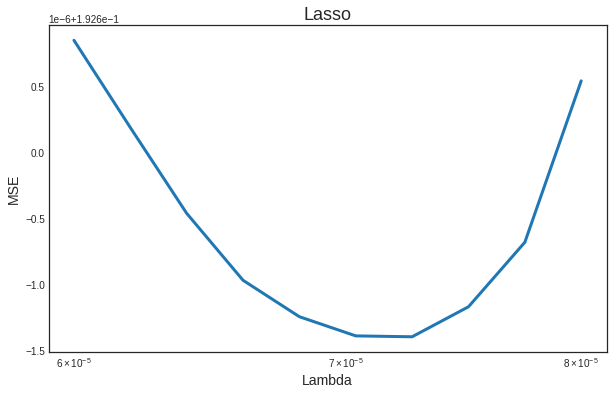

In [44]:
# Get the ideal lambda for the Lasso
lam_lasso = choose_hyper_param_by_Kfold_cv(X, y, 7, np.log10(0.00006), np.log10(0.00008), 10, False)

We observe that the optimal lambda for the Ridge regression seems to lie somewhere between $4.15$ and $4.35$ while the one for the Lasso appears to be somewhere between $0.000069$ and $0.000074$. Hence, we further adjust the grids of lambdas and repeat the above procedure again.

For a Ridge Regression we obtain that a lambda = 4.26e+00 leads to the lowest MSE = 0.1926 among the lambdas in the grid.


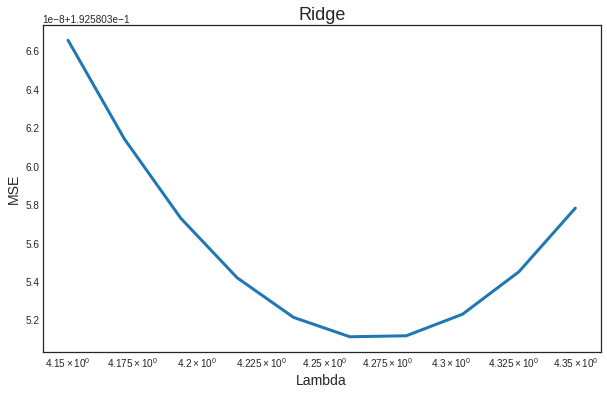

In [45]:
# Get the ideal lambda for the Ridge Regression
lam_ridge = choose_hyper_param_by_Kfold_cv(X, y, 7, np.log10(4.15), np.log10(4.35), 10, True)

For a Lasso we obtain that a lambda = 7.17e-05 leads to the lowest MSE = 0.1926 among the lambdas in the grid.


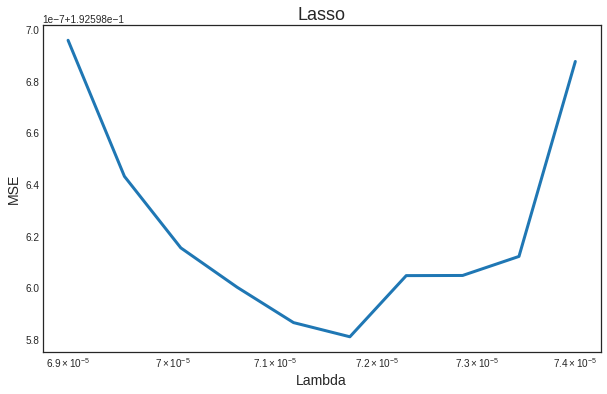

In [46]:
# Get the ideal lambda for the Lasso
lam_lasso = choose_hyper_param_by_Kfold_cv(X, y, 7, np.log10(0.000069), np.log10(0.000074), 10, False)

We observe that the optimal lambda for the Ridge regression seems to lie somewhere between $4.25$ and $4.285$ while the one for the Lasso appears to be somewhere between $0.000071$ and $0.0000725$. Hence, we further adjust the grids of lambdas and repeat the above procedure again.

For a Ridge Regression we obtain that a lambda = 4.27e+00 leads to the lowest MSE = 0.1926 among the lambdas in the grid.


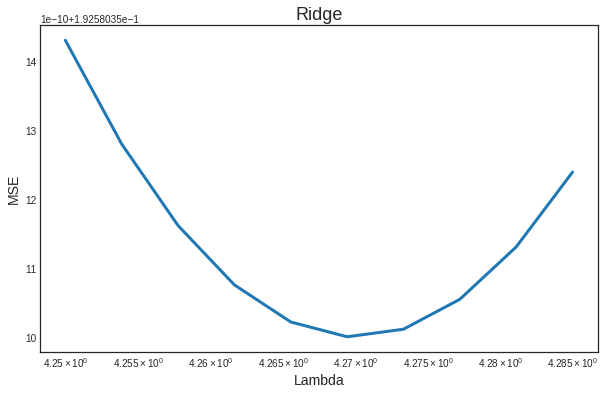

In [47]:
# Get the ideal lambda for the Ridge Regression
lam_ridge = choose_hyper_param_by_Kfold_cv(X, y, 7, np.log10(4.25), np.log10(4.285), 10, True)

For a Lasso we obtain that a lambda = 7.20e-05 leads to the lowest MSE = 0.1926 among the lambdas in the grid.


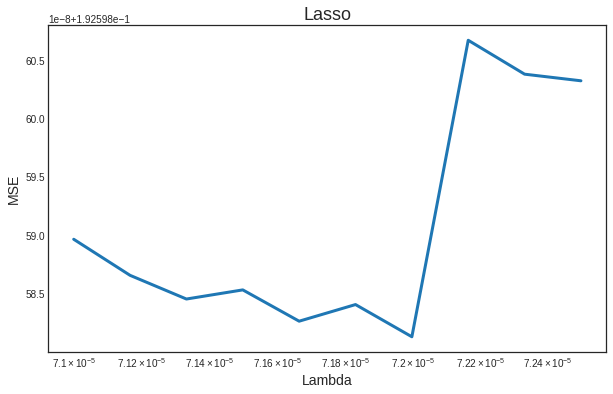

In [48]:
# Get the ideal lambda for the Lasso
lam_lasso = choose_hyper_param_by_Kfold_cv(X, y, 7, np.log10(0.000071), np.log10(0.0000725), 10, False)

We observe that the optimal lambda for the Ridge regression seems to lie somewhere between $4.268$ and $4.273$ while the one for the Lasso appears to be somewhere between $0.0000719$ and $0.0000721$. Hence, we further adjust the grids of lambdas and repeat the above procedure again.

For a Ridge Regression we obtain that a lambda = 4.27e+00 leads to the lowest MSE = 0.1926 among the lambdas in the grid.


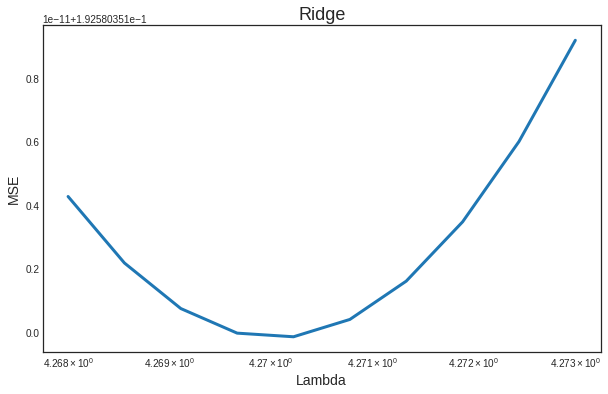

In [49]:
# Get the ideal lambda for the Ridge Regression
lam_ridge = choose_hyper_param_by_Kfold_cv(X, y, 7, np.log10(4.268), np.log10(4.273), 10, True)

For a Lasso we obtain that a lambda = 7.21e-05 leads to the lowest MSE = 0.1926 among the lambdas in the grid.


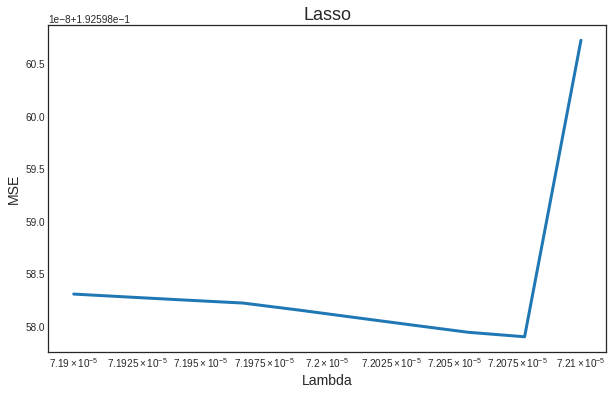

In [50]:
# Get the ideal lambda for the Lasso
lam_lasso = choose_hyper_param_by_Kfold_cv(X, y, 7, np.log10(0.0000719), np.log10(0.0000721), 10, False)

We observe that when using 7 fold cross validation the optimal lambda for the Ridge regression seems to lie somewhere between $4.268$ and $4.272$ while the one for the Lasso appears to be somewhere between $0.00007207$ and $0.00007094$. Since these ranges seems to be narrow enough to reveal an optimal lambda later on by using a refined grid of lambdas, we now repeat the same for 10 and 5 fold cross validation to find 2 further ranges for the optimal lambdas in the neighbourhood. We then calculate the optimal lambdas for 5, 7 and 10 fold cross validation and take the average value of them to use in the final model.

First we repeat the above using 10 fold cross validation.

### **Optimal Lambda by 10-fold Cross Validation**

We first apply the function for 10-fold cross validation using a rather coarse grid of lambdas to confirm that the optimal lambdas lie somewhere in the close neighbourhood of the optimal ones obtained using 7-fold cross validation.

For a Ridge Regression we obtain that a lambda = 2.15e+00 leads to the lowest MSE = 0.1926 among the lambdas in the grid.


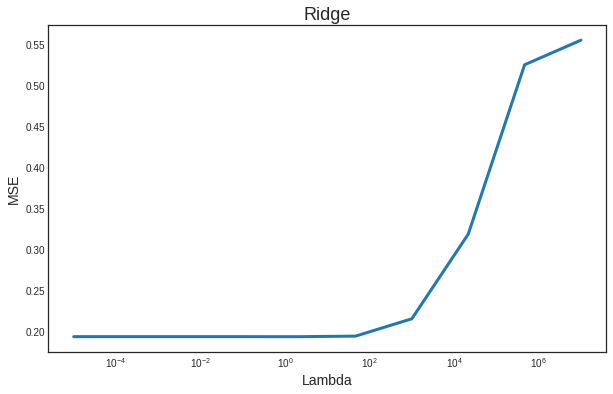

In [51]:
# Get the ideal lambda for the Ridge Regression
lam_ridge = choose_hyper_param_by_Kfold_cv(X, y, 10, -5, 7, 10, True)

For a Lasso we obtain that a lambda = 1.00e-05 leads to the lowest MSE = 0.1927 among the lambdas in the grid.


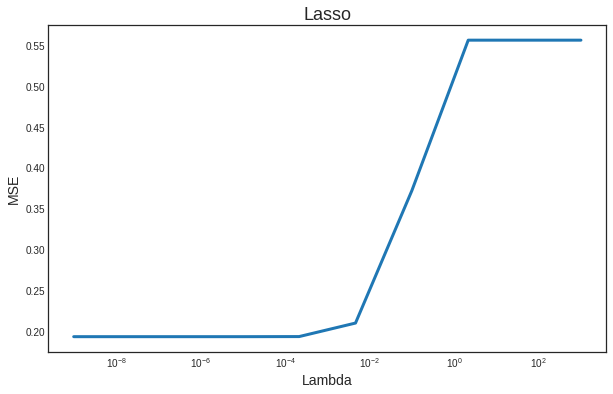

In [52]:
# Get the ideal lambda for the Lasso
lam_lasso = choose_hyper_param_by_Kfold_cv(X, y, 10, -9, 3, 10, False)

We observe that these curves look rather similar to the ones obtained using 7-fold cross validation and a coarse grid of lambdas. We therefore chose much narrower grids around the optimal lambda obtained above in the next step.

For a Ridge Regression we obtain that a lambda = 4.07e+00 leads to the lowest MSE = 0.1926 among the lambdas in the grid.


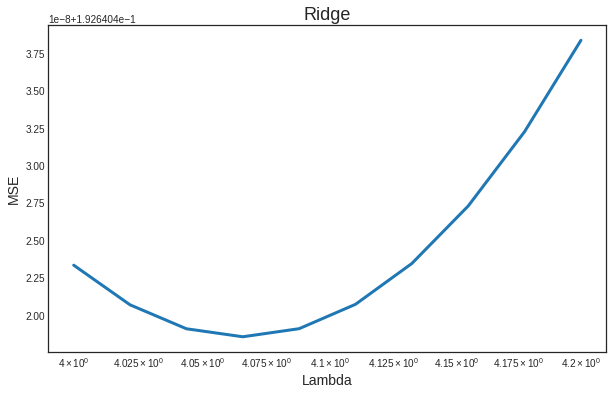

In [53]:
# Get the ideal lambda for the Ridge Regression
lam_ridge = choose_hyper_param_by_Kfold_cv(X, y, 10, np.log10(4), np.log10(4.2), 10, True)

For a Lasso we obtain that a lambda = 3.01e-05 leads to the lowest MSE = 0.1927 among the lambdas in the grid.


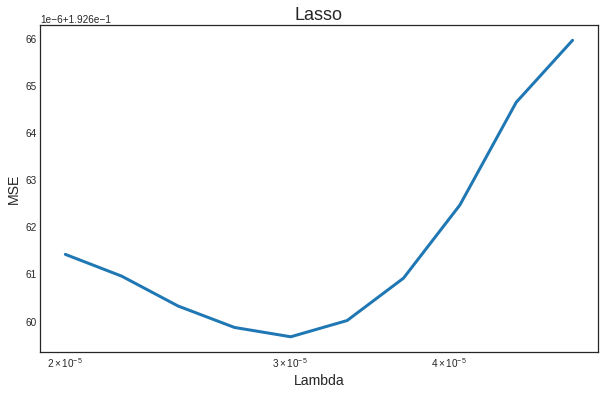

In [54]:
# Get the ideal lambda for the Lasso
lam_lasso = choose_hyper_param_by_Kfold_cv(X, y, 10, np.log10(0.00002), np.log10(0.00005), 10, False)

We observe that with 10 fold cross validation the optimal lambda for the Ridge regression seems to lie somewhere between $4.05$ and $4.1$ while the one for the Lasso appears to be somewhere between $0.000029$ and $0.000035$. Hence, we further adjust the grids of lambdas and repeat the above procedure again.

For a Ridge Regression we obtain that a lambda = 4.07e+00 leads to the lowest MSE = 0.1926 among the lambdas in the grid.


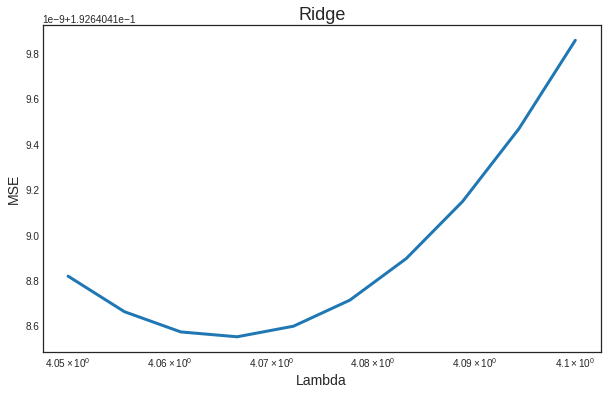

In [55]:
# Get the ideal lambda for the Ridge Regression
lam_ridge = choose_hyper_param_by_Kfold_cv(X, y, 10, np.log10(4.05), np.log10(4.1), 10, True)

For a Lasso we obtain that a lambda = 3.02e-05 leads to the lowest MSE = 0.1927 among the lambdas in the grid.


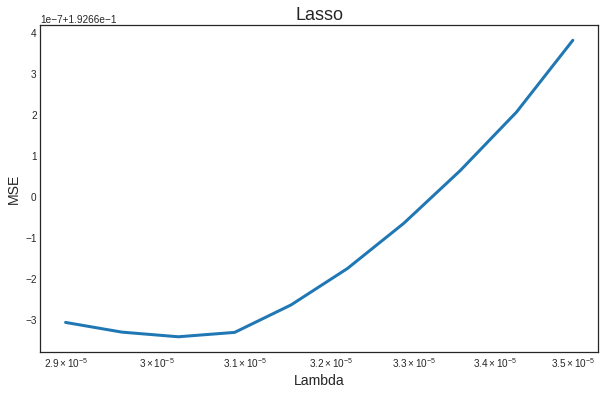

In [56]:
# Get the ideal lambda for the Lasso
lam_lasso = choose_hyper_param_by_Kfold_cv(X, y, 10, np.log10(0.000029), np.log10(0.000035), 10, False)

We observe that with 10 fold cross validation the optimal lambda for the Ridge regression seems to lie somewhere between $4.06$ and $4.075$ while the one for the Lasso appears to be somewhere between $0.0000295$ and $0.000031$. Hence, we further adjust the grids of lambdas and repeat the above procedure again.

For a Ridge Regression we obtain that a lambda = 4.06e+00 leads to the lowest MSE = 0.1926 among the lambdas in the grid.


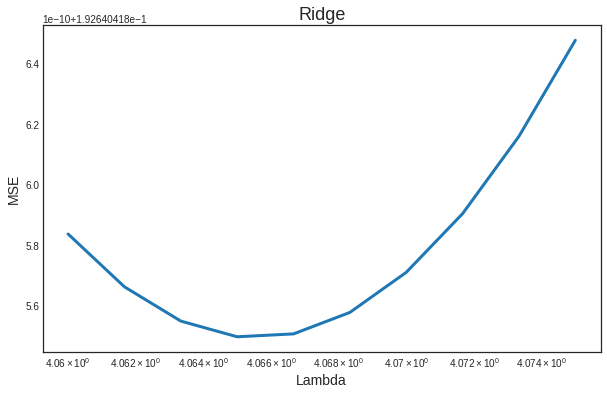

In [57]:
# Get the ideal lambda for the Ridge Regression
lam_ridge = choose_hyper_param_by_Kfold_cv(X, y, 10, np.log10(4.06), np.log10(4.075), 10, True)

For a Lasso we obtain that a lambda = 3.02e-05 leads to the lowest MSE = 0.1927 among the lambdas in the grid.


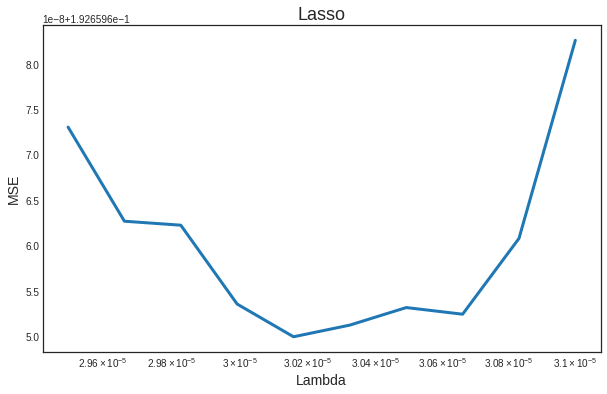

In [58]:
# Get the ideal lambda for the Lasso
lam_lasso = choose_hyper_param_by_Kfold_cv(X, y, 10, np.log10(0.0000295), np.log10(0.000031), 10, False)

We observe that when using 10 fold cross validation the optimal lambda for the Ridge regression seems to lie somewhere between $4.064$ and $4.068$ while the one for the Lasso appears to be somewhere between $0.0000301$ and $0.0000308$. Since these ranges seems to be narrow enough to reveal an optimal lambda later on by using a refined grid of lambdas, we now repeat the same for 5 fold cross validation.

### **Optimal Lambda by 5-fold Cross Validation**

We first apply the function for 5-fold cross validation using a rather coarse grid of lambdas to confirm that the optimal lambdas lie somewhere in the close neighbourhood of the optimal ones obtained using 7-fold cross validation.

For a Ridge Regression we obtain that a lambda = 2.15e+00 leads to the lowest MSE = 0.1927 among the lambdas in the grid.


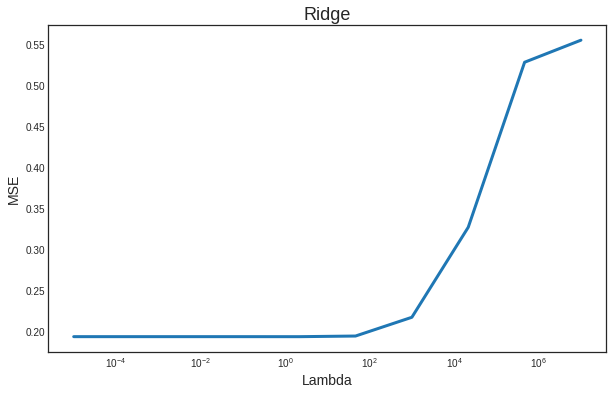

In [59]:
# Get the ideal lambda for the Ridge Regression
lam_ridge = choose_hyper_param_by_Kfold_cv(X, y, 5, -5, 7, 10, True)

For a Lasso we obtain that a lambda = 1.00e-05 leads to the lowest MSE = 0.1927 among the lambdas in the grid.


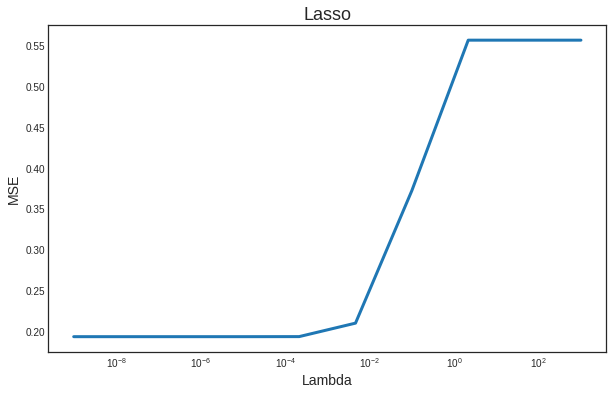

In [60]:
# Get the ideal lambda for the Lasso
lam_lasso = choose_hyper_param_by_Kfold_cv(X, y, 5, -9, 3, 10, False)

We observe that these curves look rather similar to the ones obtained using 7-fold cross validation and a coarse grid of lambdas. We therefore chose much narrower grids around the optimal lambda obtained above in the next step.

For a Ridge Regression we obtain that a lambda = 4.06e+00 leads to the lowest MSE = 0.1927 among the lambdas in the grid.


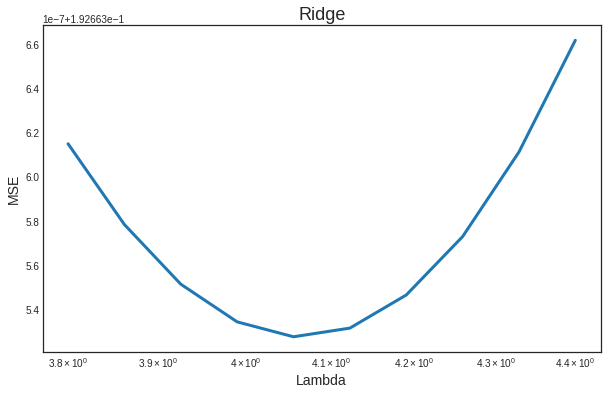

In [61]:
# Get the ideal lambda for the Ridge Regression
lam_ridge = choose_hyper_param_by_Kfold_cv(X, y, 5, np.log10(3.8), np.log10(4.4), 10, True)

For a Lasso we obtain that a lambda = 7.85e-05 leads to the lowest MSE = 0.1927 among the lambdas in the grid.


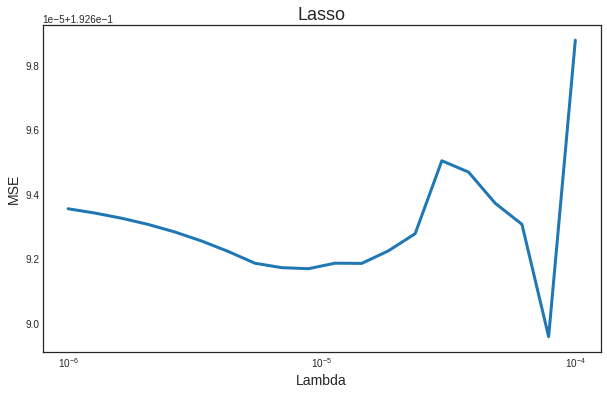

In [62]:
# Get the ideal lambda for the Lasso
lam_lasso = choose_hyper_param_by_Kfold_cv(X, y, 5, np.log10(0.000001), np.log10(0.0001), 20, False)

We observe that with 5 fold cross validation the optimal lambda for the Ridge regression seems to lie somewhere between $4$ and $4.2$ while the one for the Lasso appears to be somewhere between $0.00005$ and $0.0001$. Hence, we further adjust the grids of lambdas and repeat the above procedure again.

For a Ridge Regression we obtain that a lambda = 4.07e+00 leads to the lowest MSE = 0.1927 among the lambdas in the grid.


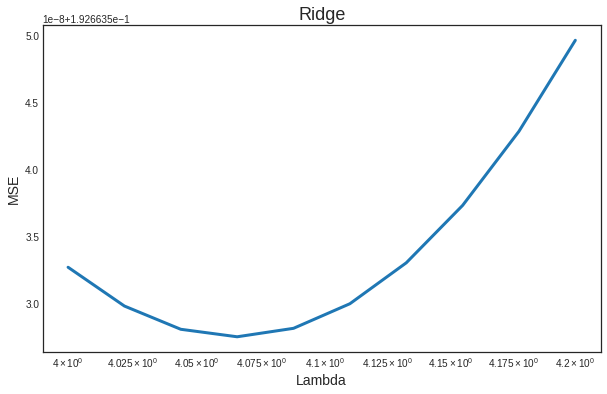

In [63]:
# Get the ideal lambda for the Ridge Regression
lam_ridge = choose_hyper_param_by_Kfold_cv(X, y, 5, np.log10(4), np.log10(4.2), 10, True)

For a Lasso we obtain that a lambda = 7.75e-05 leads to the lowest MSE = 0.1927 among the lambdas in the grid.


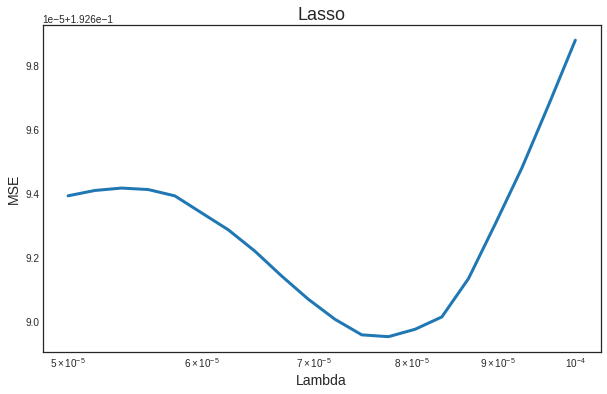

In [64]:
# Get the ideal lambda for the Lasso
lam_lasso = choose_hyper_param_by_Kfold_cv(X, y, 5, np.log10(0.00005), np.log10(0.0001), 20, False)

We observe that with 5 fold cross validation the optimal lambda for the Ridge regression seems to lie somewhere between $4.05$ and $4.08$ while the one for the Lasso appears to be somewhere between $0.000072$ and $0.000085$. Hence, we further adjust the grids of lambdas and repeat the above procedure again.

For a Ridge Regression we obtain that a lambda = 4.06e+00 leads to the lowest MSE = 0.1927 among the lambdas in the grid.


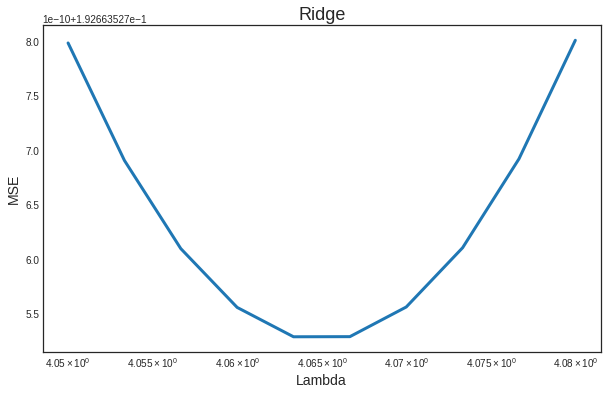

In [65]:
# Get the ideal lambda for the Ridge Regression
lam_ridge = choose_hyper_param_by_Kfold_cv(X, y, 5, np.log10(4.05), np.log10(4.08), 10, True)

For a Lasso we obtain that a lambda = 7.65e-05 leads to the lowest MSE = 0.1927 among the lambdas in the grid.


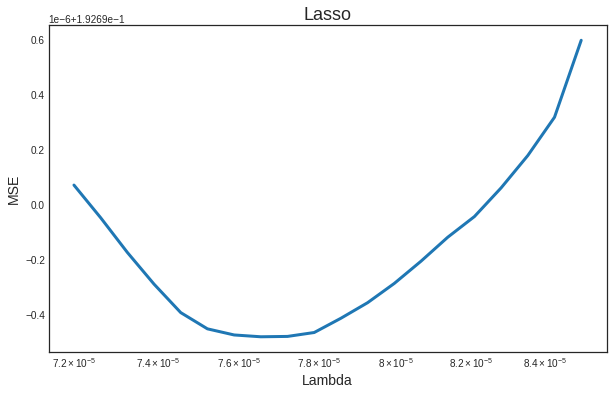

In [66]:
# Get the ideal lambda for the Lasso
lam_lasso = choose_hyper_param_by_Kfold_cv(X, y, 5, np.log10(0.000072), np.log10(0.000085), 20, False)

We observe that when using 5 fold cross validation the optimal lambda for the Ridge regression seems to lie somewhere between $4.063$ and $4.068$ while the one for the Lasso appears to be somewhere between $0.000076$ and $0.000078$. Since these ranges seems to be narrow enough to reveal an optimal lambda later on by using a refined grid of lambdas, we now repeat the same for 5 fold cross validation.

### **Final Choice of Optimal Lambda**

Now we determine the best lambdas for both, the Ridge and Lasso regression, by means of 5, 7 and 10 fold cross validation on the narrowest according range of lambdas chosing a grid of 50 lambda values for each attempt. Finally, we take the average of these optimal lambdas as our final choice for the optimal lambda.

For a Ridge Regression we obtain that a lambda = 4.27e+00 leads to the lowest MSE = 0.1926 among the lambdas in the grid.
For a Ridge Regression we obtain that a lambda = 4.07e+00 leads to the lowest MSE = 0.1926 among the lambdas in the grid.
For a Ridge Regression we obtain that a lambda = 4.06e+00 leads to the lowest MSE = 0.1927 among the lambdas in the grid.


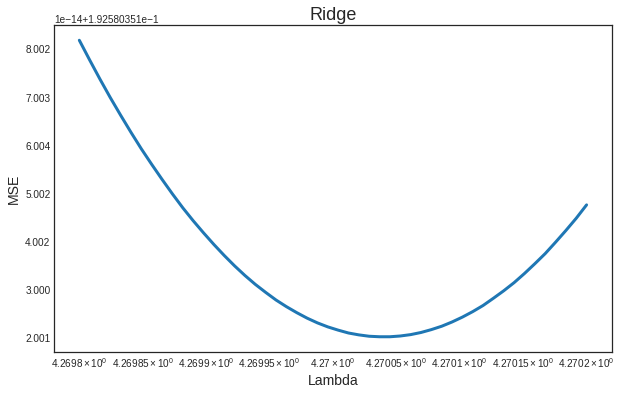

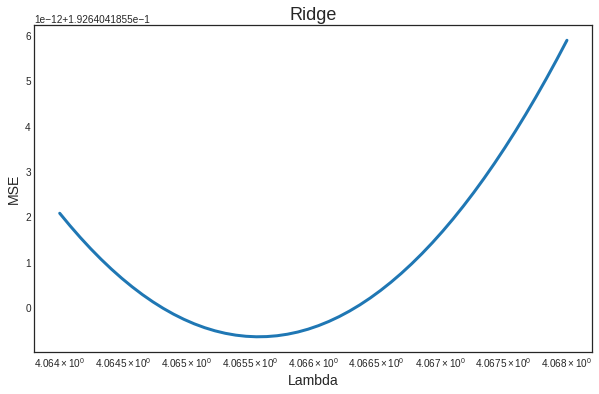

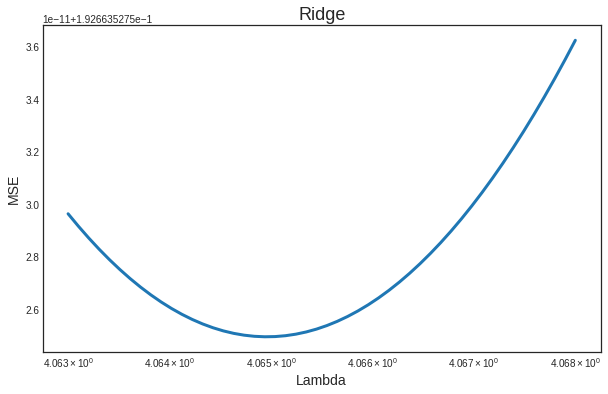

In [67]:
# Get the ideal lambda for the Ridge Regression
# Optimal lambda from 7 fold cross validation
lam_ridge_7 = choose_hyper_param_by_Kfold_cv(X, y, 7, np.log10(4.2698), np.log10(4.2702), 50, True)
# Optimal lambda from 7 fold cross validation
lam_ridge_10 = choose_hyper_param_by_Kfold_cv(X, y, 10, np.log10(4.064), np.log10(4.068), 50, True)
# Optimal lambda from 7 fold cross validation
lam_ridge_5 = choose_hyper_param_by_Kfold_cv(X, y, 5, np.log10(4.063), np.log10(4.068), 50, True)

For a Lasso we obtain that a lambda = 7.21e-05 leads to the lowest MSE = 0.1926 among the lambdas in the grid.
For a Lasso we obtain that a lambda = 3.06e-05 leads to the lowest MSE = 0.1927 among the lambdas in the grid.
For a Lasso we obtain that a lambda = 7.67e-05 leads to the lowest MSE = 0.1927 among the lambdas in the grid.


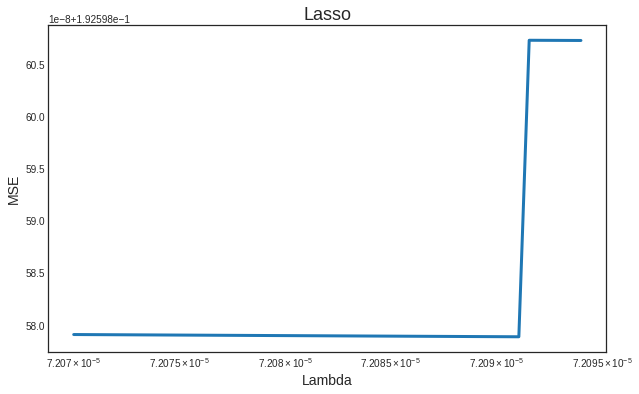

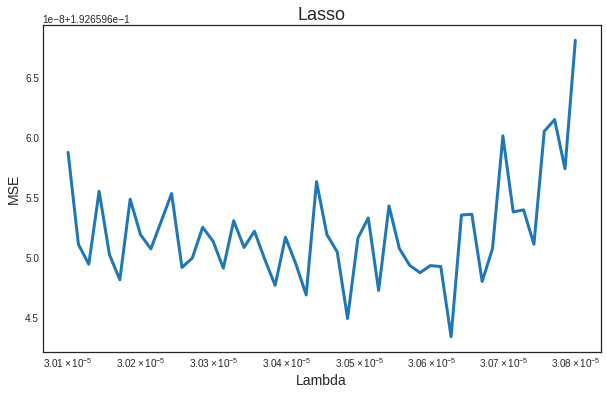

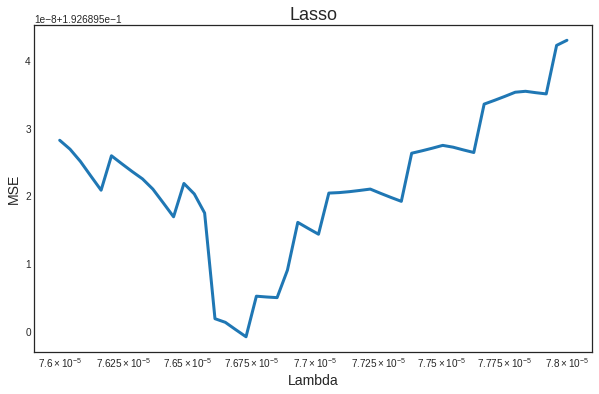

In [68]:
# Get the ideal lambda for the Lasso
# Optimal lambda from 7 fold cross validation
lam_lasso_7 = choose_hyper_param_by_Kfold_cv(X, y, 7, np.log10(0.00007207), np.log10(0.000072094), 50, False)
# Optimal lambda from 10 fold cross validation
lam_lasso_10 = choose_hyper_param_by_Kfold_cv(X, y, 10, np.log10(0.0000301), np.log10(0.0000308), 50, False)
# Optimal lambda from 5 fold cross validation
lam_lasso_5 = choose_hyper_param_by_Kfold_cv(X, y, 5, np.log10(0.000076), np.log10(0.000078), 50, False)

In [69]:
# Calculate the optimal lambdas
lam_ridge_opt = np.mean([lam_ridge_7, lam_ridge_10, lam_ridge_5])
lam_lasso_opt = np.mean([lam_lasso_7, lam_lasso_10, lam_lasso_5])

# Display the exact value of the optimal lambdas
print("Ridge lambda:", lam_ridge_opt)
print("Lasso lambda:", lam_lasso_opt)

Ridge lambda: 4.133508443038713
Lasso lambda: 5.981560182683625e-05


In [70]:
# Store the values manually, such that the above computationally expensive step does not necessarily have to be calculated each time
lam_ridge_opt = 4.133508443038713
lam_lasso_opt = 5.981560182683625e-05

### **Model Estimation**

Once we have obtained the optimal lambda values for the Ridge and Lasso, we train the models using these hyperparameters on the full training data. Then we report the training error and compare it to the one of the OLS predictions.

In [71]:
## Ridge
# Train the Ridge model using the best lambda calculated above
model_r = Ridge(lam_ridge_opt, fit_intercept=True, normalize=False).fit(X, y)
# Get the predictions on training data
y_train_pred_r = model_r.predict(X)
# Calculate the training mse
mse_ridge_train = sklearn.metrics.mean_squared_error(y, y_train_pred_r)


## Lasso
# Train the Lasso model using the best lambda calculated above
model_l = Lasso(lam_lasso_opt, fit_intercept=True, normalize=False).fit(X, y)
# Get the predictions on training data
y_train_pred_l = model_l.predict(X)
# Calculate the training mse
mse_lasso_train = sklearn.metrics.mean_squared_error(y, y_train_pred_l)


## Report the result
print('For Ridge Regression using lambda = %.2e we obtain the following training MSE' % (lam_ridge_opt))
print('--------------------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_ridge_train)

print('\n\nFor Lasso using lambda = %.2e we obtain the following training MSE' % (lam_lasso_opt))
print('---------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_lasso_train)

For Ridge Regression using lambda = 4.13e+00 we obtain the following training MSE
--------------------------------------------------------------------------------

MSE (Training) = 0.1915


For Lasso using lambda = 5.98e-05 we obtain the following training MSE
---------------------------------------------------------------------

MSE (Training) = 0.1915


In [72]:
# Take a look at the resulting coefficients of the Ridge Regression
model_r.coef_

array([ 0.06044118,  0.24602783,  0.24288575,  0.30726691,  0.62755019,
        0.46470098, -0.0873884 , -0.04227932,  0.09873803, -0.02904579,
        0.05704327, -0.02681271, -0.12969955, -0.09037308, -0.08899836,
       -0.10861558, -0.05737935, -0.04742677,  0.07919833, -0.13204905,
        0.02302297, -0.17358825, -0.12071476, -0.0487999 , -0.02673728,
       -0.14014616,  0.02470369,  0.00122367, -0.06980155,  0.00637245,
       -0.02996768, -0.08548226,  0.04852365,  0.03511627,  0.18264751,
        0.21023521,  0.31992473,  0.07210513,  0.05696379, -0.18295733,
       -0.10250156, -0.10331246, -0.02310639,  0.05823411,  0.14036003,
        0.21328359, -0.38210137, -0.2268258 , -0.1403159 , -0.09203536,
       -0.06862075,  0.05260559, -0.06012738, -0.11390711, -0.23386019,
       -0.24043433, -0.34853292, -0.42644563, -0.4988888 ,  0.15936339,
        0.24350806,  0.32701933,  0.41496713,  0.55738151])

In [73]:
# Take a look at the resulting coefficients of the Lasso
model_l.coef_

array([ 6.03502272e-02,  2.46501141e-01,  2.39978770e-01,  3.08607748e-01,
        6.36582528e-01,  4.67051648e-01, -8.55349885e-02, -3.89253088e-02,
        9.88744416e-02, -2.45522957e-02,  5.32518576e-02, -2.42313062e-02,
       -8.19894168e-02, -4.07701119e-02, -4.13617945e-02, -6.11211609e-02,
       -3.41221499e-03, -0.00000000e+00,  8.41757428e-02, -1.26094411e-01,
        2.42076104e-02, -1.69912424e-01, -1.17264732e-01, -3.76952796e-02,
       -2.28418889e-02, -1.41503881e-01,  1.78643302e-02,  0.00000000e+00,
       -7.09029847e-02,  6.13280797e-04, -3.10847933e-02, -9.55367418e-02,
        3.66935715e-02,  2.41057408e-02,  1.69800159e-01,  1.96408434e-01,
        3.07505507e-01,  7.18437401e-02,  5.65709325e-02, -1.59222655e-01,
       -0.00000000e+00, -8.00166376e-02, -0.00000000e+00,  8.03474763e-02,
        1.62644351e-01,  2.45961075e-01, -3.70412556e-01, -2.14440342e-01,
       -1.27729236e-01, -7.92349447e-02, -5.62242318e-02,  5.24949355e-02,
       -5.93684224e-02, -

In [74]:
# Check how many coefficients are set to 0 when a Lasso is performed
np.sum(model_l.coef_ == 0)

4

In [75]:
# Take a look at the difference between the resulting coefficients from the Ridge and Lasso regression
model_r.coef_ - model_l.coef_

array([ 9.09510688e-05, -4.73313128e-04,  2.90697615e-03, -1.34083716e-03,
       -9.03233503e-03, -2.35067193e-03, -1.85340829e-03, -3.35401167e-03,
       -1.36412971e-04, -4.49348968e-03,  3.79141605e-03, -2.58140167e-03,
       -4.77101310e-02, -4.96029730e-02, -4.76365682e-02, -4.74944163e-02,
       -5.39671386e-02, -4.74267697e-02, -4.97740944e-03, -5.95464234e-03,
       -1.18463860e-03, -3.67582622e-03, -3.45002753e-03, -1.11046224e-02,
       -3.89539482e-03,  1.35771717e-03,  6.83936199e-03,  1.22367376e-03,
        1.10143017e-03,  5.75916435e-03,  1.11711484e-03,  1.00544798e-02,
        1.18300760e-02,  1.10105308e-02,  1.28473473e-02,  1.38267770e-02,
        1.24192196e-02,  2.61386805e-04,  3.92859899e-04, -2.37346738e-02,
       -1.02501556e-01, -2.32958250e-02, -2.31063864e-02, -2.21133640e-02,
       -2.22843168e-02, -3.26774876e-02, -1.16888109e-02, -1.23854598e-02,
       -1.25866688e-02, -1.28004178e-02, -1.23965171e-02,  1.10656878e-04,
       -7.58960222e-04, -

In [76]:
# Calculate the MSE of the OLS predictions
y_train_pred_OLS = data['lncaphat_OLS'][data['training'] == 1]
mse_ols_train = sklearn.metrics.mean_squared_error(y, y_train_pred_OLS)

# Report the Results
print('In the following we provide an overview of the training MSE from the OLS, Ridge and Lasso')
print('--------------------------------------------------------------------------------\n')
print("OLS training MSE:", mse_ols_train)
print("Lasso training MSE:", mse_lasso_train)
print("Ridge training MSE:", mse_ridge_train)

In the following we provide an overview of the training MSE from the OLS, Ridge and Lasso
--------------------------------------------------------------------------------

OLS training MSE: 0.19146992519582293
Lasso training MSE: 0.19151890946863923
Ridge training MSE: 0.19148297414579873


We observe that both, the Ridge and Lasso regression appear to perform similar to the OLS model, while both exhibit a slightly higher MSE. Furthermore, we observe that the Lasso regression sets 4 coefficients to 0. However, most coefficients are rather similar in both models.

In [77]:
# Calculate the Test MSE of all models
# OLS
y_test_pred_OLS = data['lncaphat_OLS'][data['training'] == 0]
mse_ols_test = sklearn.metrics.mean_squared_error(ytest, y_test_pred_OLS)
mse_ols_test

# Ridge
# Get the predictions on test data
y_test_pred_r = model_r.predict(Xtest)
# Calculate the test mse
mse_ridge_test = sklearn.metrics.mean_squared_error(ytest, y_test_pred_r)

# Lasso
# Get the predictions on test data
y_test_pred_l = model_l.predict(Xtest)
# Calculate the test mse
mse_lasso_test = sklearn.metrics.mean_squared_error(ytest, y_test_pred_l)

# Report the Results
print('In the following we provide an overview of the test MSE from the OLS, Ridge and Lasso')
print('--------------------------------------------------------------------------------\n')
print("OLS test MSE:", mse_ols_test)
print("Lasso test MSE:", mse_lasso_test)
print("Ridge test MSE:", mse_ridge_test)

In the following we provide an overview of the test MSE from the OLS, Ridge and Lasso
--------------------------------------------------------------------------------

OLS test MSE: 0.19086802245585383
Lasso test MSE: 0.1909464182406104
Ridge test MSE: 0.19088742850405135


### **Plot: Predicted vs Actual**

Finally, we plot the resulting predictions against the actual values of log consumption for both models.

In [78]:
# Get a threshold p to classify housholds as eligible or not eligible for the subsidy
p = np.percentile(y, 35)
p

5.56879945

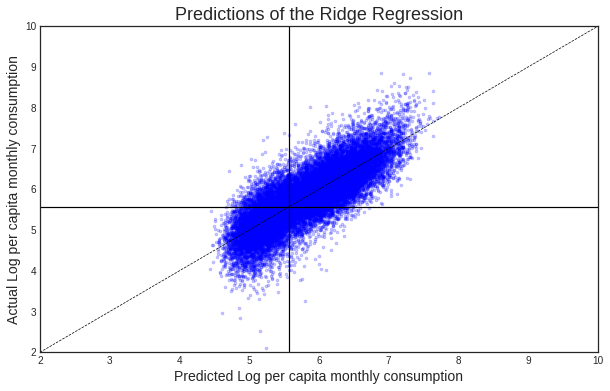

In [79]:
# Plot the predictions of the Ridge
fig, ax = plt.subplots()
ax.scatter(y_train_pred_r, y, c='blue', alpha = .2, s=7)
plt.xlim((2,10))
plt.ylim((2,10))
plt.title("Predictions of the Ridge Regression")
ax.axhline(y=p, color='black', linewidth=1.2)
ax.axvline(x=p, color='black', linewidth=1.2)
plt.xlabel('Predicted Log per capita monthly consumption')
plt.ylabel('Actual Log per capita monthly consumption')
line = mlines.Line2D([0, 1], [0, 1], color='black', linestyle='--', linewidth=0.7)
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
plt.show()

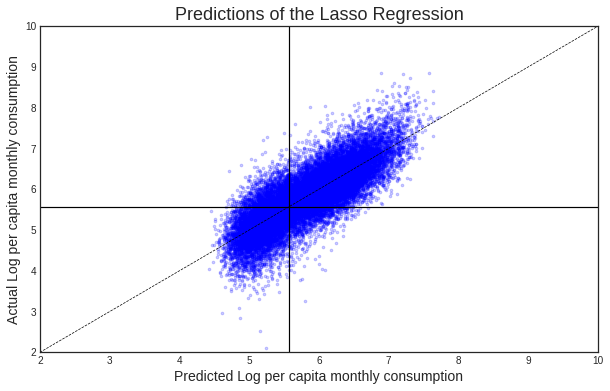

In [80]:
# Plot the predictions of the Lasso
fig, ax = plt.subplots()
ax.scatter(y_train_pred_l, y, c='blue', alpha = .2, s=7)
plt.xlim((2,10))
plt.ylim((2,10))
plt.title("Predictions of the Lasso Regression")
ax.axhline(y=p, color='black', linewidth=1.2)
ax.axvline(x=p, color='black', linewidth=1.2)
plt.xlabel('Predicted Log per capita monthly consumption')
plt.ylabel('Actual Log per capita monthly consumption')
line = mlines.Line2D([0, 1], [0, 1], color='black', linestyle='--', linewidth=0.7)
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
plt.show()

### **Plot: Inclusion vs Exclusion Error**

In this last section, we create the ROC curves for both models.

In [81]:
# Ridge
pred = np.array(y_train_pred_r)
actual = np.array(y)
df = pd.DataFrame({'Predicted_values':pred, 'Actual_values':actual})

# Calcualte the inclusion and exclusion error for thresholds equal to the percentiles ranging from 1 to 100 by steps of 0.1
incl_error = []
excl_error = []

for thresh_pctl in np.arange(1, 100, 0.1): 
    # Get the according threshold
    p = np.percentile(y, thresh_pctl)
    
    # Calculate the inclusion error rate
    # First, count the number of flase inclusions (false positives FP) for the given threshold
    FP = df[(df['Predicted_values'] < p) & (df['Actual_values'] > p)].count()
    # Count the total number of actual values above the threshold (i.e. false positives + true negatives)
    TN_FP = df[df['Actual_values'] > p].count()
    # Calculate the inclusion error as the FP-ratio
    FP_ratio = FP / TN_FP
    inclusion_error = FP_ratio
    
    # Calculate the exclusion error rate analoguously
    FN = df[(df['Predicted_values'] > p) & (df['Actual_values'] < p)].count()
    TP_FN = df[df['Actual_values'] < p].count()
    TP_ratio = FN / TP_FN               # Essentially this is the true exclusion error
    exclusion_error = 1 - TP_ratio      # But for the ROC curve we need 1-exclusion error
    
    incl_error.append(inclusion_error)
    excl_error.append(exclusion_error)

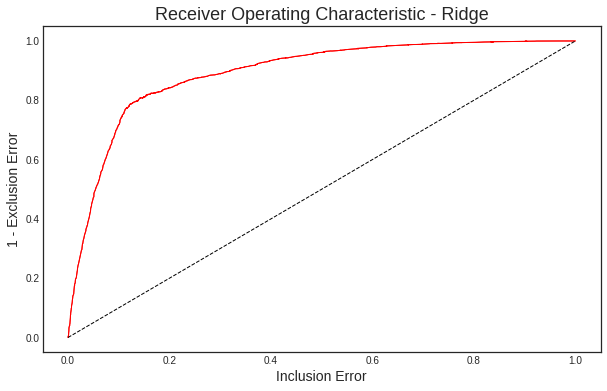

In [82]:
# Plot the ROC curve of the Rige Regression
plt.plot(incl_error, excl_error, color='red', lw = 1)
plt.xlabel('Inclusion Error')
plt.ylabel('1 - Exclusion Error')
plt.title('Receiver Operating Characteristic - Ridge')
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.show()

In [83]:
# Lasso
pred = np.array(y_train_pred_l)
actual = np.array(y)
df = pd.DataFrame({'Predicted_values':pred, 'Actual_values':actual})

# Calcualte the inclusion and exclusion error for thresholds equal to the percentiles ranging from 1 to 100 by steps of 0.1
incl_error = []
excl_error = []

for thresh_pctl in np.arange(1, 100, 0.1): 
    # Get the according threshold
    p = np.percentile(y, thresh_pctl) 
    
    # Calculate the inclusion error rate
    # First, count the number of flase inclusions (false positives FP) for the given threshold
    FP = df[(df['Predicted_values'] < p) & (df['Actual_values'] > p)].count()
    # Count the total number of actual values above the threshold (i.e. false positives + true negatives)
    TN_FP = df[df['Actual_values'] > p].count()
    # Calculate the inclusion error as the FP-ratio
    FP_ratio = FP / TN_FP
    inclusion_error = FP_ratio

    # Calculate the exclusion error rate analoguously  
    FN = df[(df['Predicted_values'] > p) & (df['Actual_values'] < p)].count()
    TP_FN = df[df['Actual_values'] < p].count()
    TP_ratio = FN / TP_FN               # Essentially this is the true exclusion error
    exclusion_error = 1 - TP_ratio      # But for the ROC curve we need 1-exclusion error
    
    incl_error.append(inclusion_error)
    excl_error.append(exclusion_error)

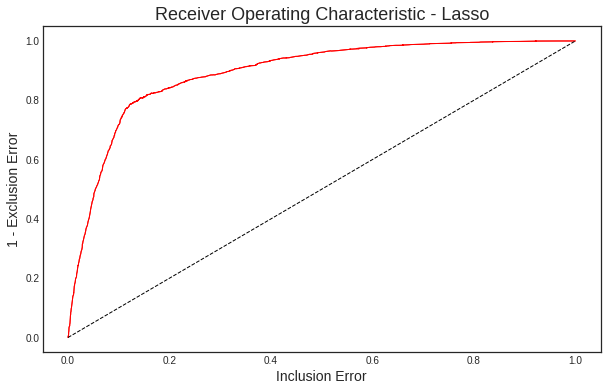

In [84]:
# Plot the ROC curve of the Lasso
plt.plot(incl_error, excl_error, color='red', lw = 1)
plt.xlabel('Inclusion Error')
plt.ylabel('1 - Exclusion Error')
plt.title('Receiver Operating Characteristic - Lasso')
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.show()

## **Basis Expansion Approach**

### **Preparation**

In the following we apply a basis expansion of degree 2 to our dataset. Since the matrix of explanatory variables solely consists of indicator variables, we do not include any squares of the features, as these would just coincide with the original variables themselves and therefore would lead to multicollinearity issues. The resulting X matrix therefore consists of the 64 original explanatory variables and each possible interaction term we can construct with them. This leads to a total of 2'080 explanatory variables we can use to train a model. However, as we do not want to rely on all 2'080 features, we decide to train a Lasso model (which inherently performs variable selection) on this new extended dataset in the following. We refer to this new Lasso as the "extended Lasso model".

In [85]:
# Apply the a basis expansion of degree 2 to the data, using solely interaction terms
poly = PolynomialFeatures(degree=2, interaction_only = True, include_bias= False)
Xpoly = poly.fit_transform(X)

# Check the shape of the data
Xpoly.shape

(22674, 2080)

With this step, we expand the dataset as described above. We can see that this indeed leads to a set of 2'080 features.

### **Optimal Lambda by 5-fold Cross Validation**

Since cross validation with such a large set of features appears to be computationally much more expensive than above, we decide to simply apply 5-fold cross validation to determine an optimal lambda for the extended Lasso model. Besides this, however, we proceed analoguously to the methodology used in the basic approach above.

We then start by running the above defined function **choose_hyper_param_by_Kfold_cv** using a rather coarse grid of lambdas (from $10^{-15}$ to $10^{10}$ by $10$ steps) to get a first impression of where the optimal lambda might be located. Thereafter, we continue by narrowing and refining the grid step by step until we arrive at a sufficiently precise value for the optimal lambda.

For a Lasso we obtain that a lambda = 1.29e-04 leads to the lowest MSE = 0.1855 among the lambdas in the grid.


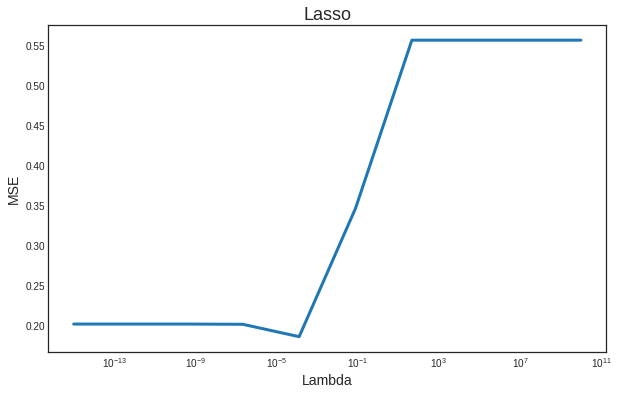

In [86]:
# Get the ideal lambda for the extended Lasso model
lam_lasso_poly = choose_hyper_param_by_Kfold_cv(Xpoly, y, 5, -15, 10, 10, False)

We observe that the optimal lambda seems to lie somewhere between $10^{-6}$ and $10^{-1}$. Hence, we repeat the above procedure using a more narrow grid of lambdas.

For a Lasso we obtain that a lambda = 1.67e-04 leads to the lowest MSE = 0.1852 among the lambdas in the grid.


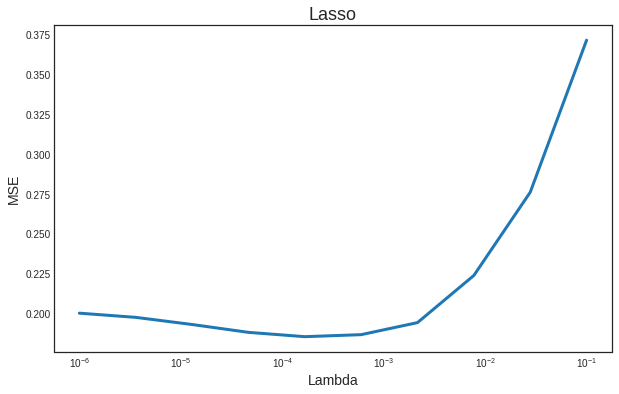

In [87]:
# Get the ideal lambda for the extended Lasso model
lam_lasso_poly = choose_hyper_param_by_Kfold_cv(Xpoly, y, 5, -6, -1, 10, False)

We observe that the optimal lambda seems to lie somewhere between $10^{-4}$ and $10^{-3}$. Hence, we repeat the above procedure using a more narrow grid of lambdas.

For a Lasso we obtain that a lambda = 2.15e-04 leads to the lowest MSE = 0.1851 among the lambdas in the grid.


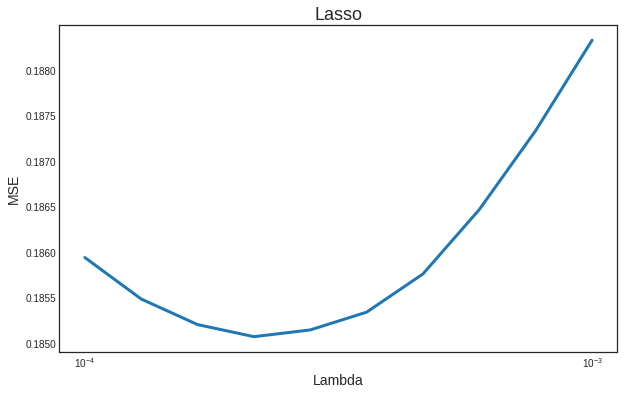

In [88]:
# Get the ideal lambda for the extended Lasso model
lam_lasso_poly = choose_hyper_param_by_Kfold_cv(Xpoly, y, 5, -4, -3, 10, False)

We observe that the optimal lambda seems to lie somewhere between $0.00015$ and $0.0003$. Hence, we repeat the above procedure using a more narrow grid of lambdas.

For a Lasso we obtain that a lambda = 2.20e-04 leads to the lowest MSE = 0.1851 among the lambdas in the grid.


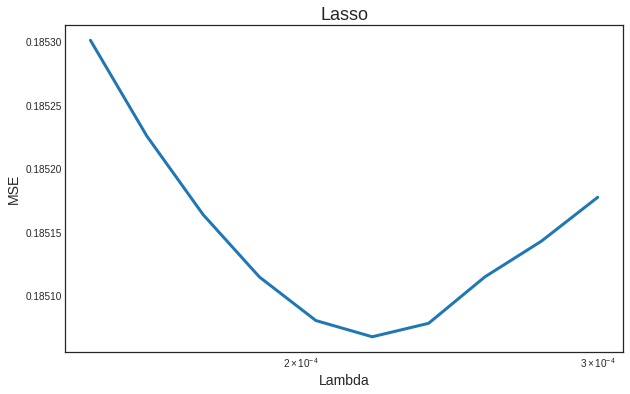

In [89]:
# Get the ideal lambda for the extended Lasso model
lam_lasso_poly = choose_hyper_param_by_Kfold_cv(Xpoly, y, 5, np.log10(0.00015), np.log10(0.0003), 10, False)

We observe that the optimal lambda seems to lie somewhere between $0.0002$ and $0.00024$. Hence, we repeat the above procedure using a more narrow grid of lambdas.

For a Lasso we obtain that a lambda = 2.26e-04 leads to the lowest MSE = 0.1851 among the lambdas in the grid.


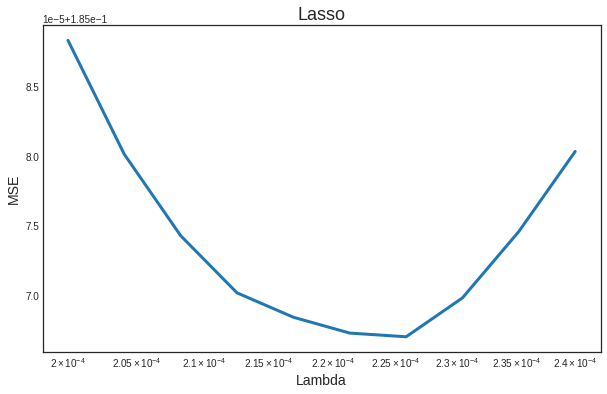

In [90]:
# Get the ideal lambda for the extended Lasso model
lam_lasso_poly = choose_hyper_param_by_Kfold_cv(Xpoly, y, 5, np.log10(0.0002), np.log10(0.00024), 10, False)

We observe that when using 5 fold cross validation the optimal lambda for the extended Lasso model appears to be somewhere between $0.00022$ and $0.00023$. Since this range seems to be narrow enough to reveal an optimal lambda, we repeat the above a last time using a refined grid of lambdas. The resulting lambda value from this step then serves as the final optimal lambda which we use to train the extended Lasso model on the whole training data.

For a Lasso we obtain that a lambda = 2.26e-04 leads to the lowest MSE = 0.1851 among the lambdas in the grid.


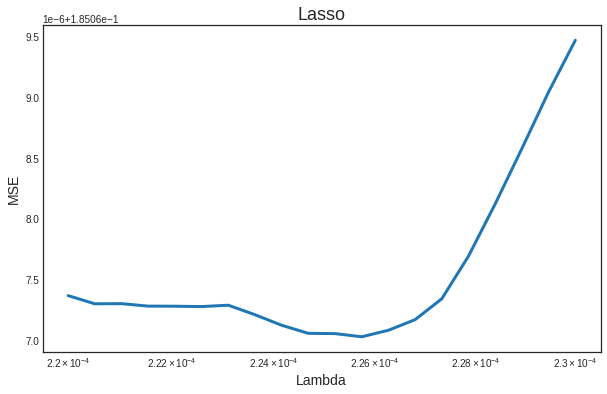

In [91]:
# Get the ideal lambda for the extended Lasso model
lam_lasso_poly = choose_hyper_param_by_Kfold_cv(Xpoly, y, 5, np.log10(0.00022), np.log10(0.00023), 20, False)

In [92]:
# Display the exact value of the optimal lambda
print("Extended Lasso lambda:", lam_lasso_poly)

Extended Lasso lambda: 0.00022573523305065713


In [93]:
# Store the value manually, such that the above computationally expensive steps do not necessarily have to be calculated each time
lam_lasso_poly = 0.00022573523305065713

### **Model Estimation**

Once we have obtained an optimal lambda value for the extended Lasso model, we train the model using this hyperparameter on the full training data. Then we report the training error and compare it to the one of the OLS predictions.

In [94]:
# Train the extended Lasso model using the best lambda calculated above
model_poly_l = Lasso(lam_lasso_poly, fit_intercept=True, normalize=False).fit(Xpoly, y)
# Get the predictions
y_train_pred_poly_l = model_poly_l.predict(Xpoly)
# Calculate the training mse
mse_poly_lasso_train = sklearn.metrics.mean_squared_error(y, y_train_pred_poly_l)

## Report the result
print('\n\nFor the extended Lasso using lambda = %.2e we obtain the following training MSE' % (lam_lasso_poly))
print('---------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_poly_lasso_train)



For the extended Lasso using lambda = 2.26e-04 we obtain the following training MSE
---------------------------------------------------------------------

MSE (Training) = 0.1756


In [95]:
# Check how many coefficients are set to 0
np.sum(model_poly_l.coef_ == 0)

1582

As we can see, the Lasso model forces 1'582 parameters to be equal to 0. Hence, the model only uses 498 of the 2080 available features.

In [96]:
# Calculate the MSE of the OLS predictions
y_train_pred_OLS = data['lncaphat_OLS'][data['training'] == 1]
mse_ols_train = sklearn.metrics.mean_squared_error(y, y_train_pred_OLS)

# Report the Results
print('In the following we provide an overview of the training MSE from the OLS and extended Lasso')
print('--------------------------------------------------------------------------------\n')
print("OLS training MSE:", mse_ols_train)
print("Extended Lasso training MSE:", mse_poly_lasso_train)

In the following we provide an overview of the training MSE from the OLS and extended Lasso
--------------------------------------------------------------------------------

OLS training MSE: 0.19146992519582293
Extended Lasso training MSE: 0.17558674787016026


We observe that after applying the basis expansion approach the extended Lasso model is indeed able to outperform the MSE of the OLS predictions on the training set.

In [97]:
# Calculate the Test MSE of all models

# Apply the a basis expansion of degree 2 to the test data, using solely interaction terms
poly = PolynomialFeatures(degree=2, interaction_only = True, include_bias= False)
Xtestpoly = poly.fit_transform(Xtest)

# Get the predictions on test data
y_test_pred_poly_l = model_poly_l.predict(Xtestpoly)
# Calculate the test mse
mse_poly_lasso_test = sklearn.metrics.mean_squared_error(ytest, y_test_pred_poly_l)

# Report the Results
print('In the following we provide an overview of the test MSE from the OLS and extended Lasso')
print('--------------------------------------------------------------------------------\n')
print("OLS test MSE:", mse_ols_test)
print("Extended Lasso test MSE:", mse_poly_lasso_test)

In the following we provide an overview of the test MSE from the OLS and extended Lasso
--------------------------------------------------------------------------------

OLS test MSE: 0.19086802245585383
Extended Lasso test MSE: 0.18347038540205254


### **Plot: Predicted vs Actual**

Finally, we plot the resulting predictions against the actual values of log consumption.

In [98]:
# Get a threshold p to classify housholds as eligible or not eligible for the subsidy
p = np.percentile(y, 35)
p

5.56879945

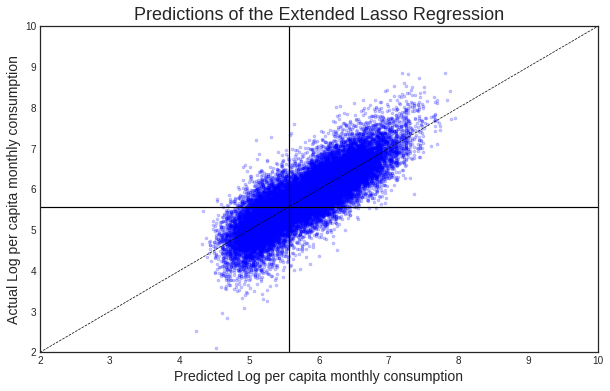

In [99]:
# Plot the predictions of the extended Lasso
fig, ax = plt.subplots()
ax.scatter(y_train_pred_poly_l, y, c='blue', alpha = .2, s=7)
plt.xlim((2,10))
plt.ylim((2,10))
plt.title("Predictions of the Extended Lasso Regression")
ax.axhline(y=p, color='black', linewidth=1.2)
ax.axvline(x=p, color='black', linewidth=1.2)
plt.xlabel('Predicted Log per capita monthly consumption')
plt.ylabel('Actual Log per capita monthly consumption')
line = mlines.Line2D([0, 1], [0, 1], color='black', linestyle='--', linewidth=0.7)
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
plt.show()

### **Plot: Inclusion vs Exclusion Error**

In this last section, we create the ROC curve for the model.

In [100]:
# Extended Lasso
pred = np.array(y_train_pred_poly_l)
actual = np.array(y)
df = pd.DataFrame({'Predicted_values':pred, 'Actual_values':actual})

# Calcualte the inclusion and exclusion error for thresholds equal to the percentiles ranging from 1 to 100 by steps of 0.1
incl_error = []
excl_error = []

for thresh_pctl in np.arange(1, 100, 0.1): 
    # Get the according threshold
    p = np.percentile(y, thresh_pctl) 
    
    # Calculate the inclusion error rate
    # First, count the number of flase inclusions (false positives FP) for the given threshold
    FP = df[(df['Predicted_values'] < p) & (df['Actual_values'] > p)].count()
    # Count the total number of actual values above the threshold (i.e. false positives + true negatives)
    TN_FP = df[df['Actual_values'] > p].count()
    # Calculate the inclusion error as the FP-ratio
    FP_ratio = FP / TN_FP
    inclusion_error = FP_ratio

    # Calculate the exclusion error rate analoguously  
    FN = df[(df['Predicted_values'] > p) & (df['Actual_values'] < p)].count()
    TP_FN = df[df['Actual_values'] < p].count()
    TP_ratio = FN / TP_FN               # Essentially this is the true exclusion error
    exclusion_error = 1 - TP_ratio      # But for the ROC curve we need 1-exclusion error
    
    incl_error.append(inclusion_error)
    excl_error.append(exclusion_error)

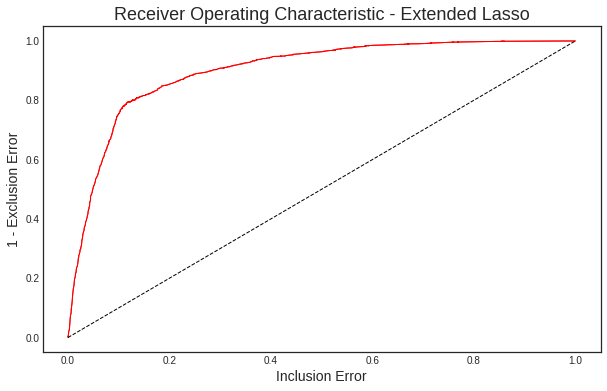

In [101]:
# Plot the ROC curve of the extended Lasso
plt.plot(incl_error, excl_error, color='red', lw = 1)
plt.xlabel('Inclusion Error')
plt.ylabel('1 - Exclusion Error')
plt.title('Receiver Operating Characteristic - Extended Lasso')
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.show()

### **Extract Predictions**

Finally, we create predictions for the whole dataset (except for observations which contain missing values for any feature) and extract the csv file as desired. This file is then merged with the other predictions we want to submit.

In [102]:
# Apply the a basis expansion of degree 2 to the full data, using solely interaction terms
poly = PolynomialFeatures(degree=2, interaction_only = True, include_bias= False)
Xfullpoly = poly.fit_transform(X_full)

# Get the predictions on test data
y_full_pred_poly_l = model_poly_l.predict(Xfullpoly)

# Extract the CSV file as needed
data['groupprediction_Lasso'] = y_full_pred_poly_l
Lassopredictions = data[['id_for_matlab','hhid','training','lnpercapitaconsumption','groupprediction_Lasso']]
Lassopredictions.to_csv(r'lasso_predictions.csv', index = False, header=True)

### **Social Welfare Plot**

In this section we replicate the welfare plot shown in Figure 5 of Hanna & Olken (2018). However, we use the predictions from the extended Lasso model here instead of the OLS predictions.

In [103]:
# Read in the data
data = pd.read_csv('data_preprocessed_full_V2.csv')
# Add the predictions
data['groupprediction_Lasso'] = y_full_pred_poly_l
# Get the shape of the data
data.shape

(45378, 74)

In [104]:
Ks = 100

u = []
incl_error = []
B = []
incomes = []

rho = 3
monthly_budget = 880000000/12
hh = 6750000
total_sample = 182215
#bonus_hh = 2.253/12
bonus_hh = 2.253


# Here, we calculate the function for the social welfare graph. 

# We again start by introducing a loop to the function that gives us the different utilities per cutoff value. 

for i in np.arange(1, Ks, 0.1):
    
 # Here, we again define the different inclusion errors per eligibility cutoff.
    p = np.percentile(data['lnpercapitaconsumption'], i)

    FP = np.sum(np.where(((data['groupprediction_Lasso'] < p) & (data['lnpercapitaconsumption'] > p)), data['h_hhsize'] , 0))
    TN_FP = np.sum(np.where(data['lnpercapitaconsumption'] > p, data['h_hhsize'], 0)) # actual negatives/not eligible hh
    FP_ratio = FP / TN_FP
    inclusion_error = FP_ratio
    
# Here below, we then define the code to replicate the utility scores.
    cons = data.percapitaconsumption
    incl_p = data['lnpercapitaconsumption'] < p  #index of actual positives/eligible hh
    num_incl = incl_p * data['h_hhsize']         #number of individuals to include/who are eligible
    hh_incl = np.sum(incl_p[data['training'] == 1]) # number of included/eligible hh in the training data
    pct_hh_incl = hh_incl / total_sample  
    national_hh_incl = hh * pct_hh_incl 
    per_hh_benefits = monthly_budget / national_hh_incl
# Important: Also include the bonus for UBI settings
    benefits = incl_p * per_hh_benefits + bonus_hh*np.where(inclusion_error == 1, 1, 0)
    percapita_benefits = benefits / data['h_hhsize']
    income = cons + percapita_benefits
    Income = income[data['training'] == 1]
    utility = (np.sum(Income**(1-rho)))/(1-rho)
    u.append(utility)
    incl_error.append(inclusion_error)

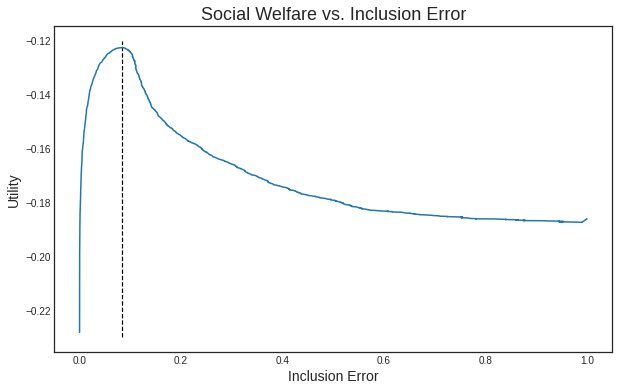

In [105]:
# Plot the results
plt.plot(incl_error, u, lw=1.5)
plt.xlabel('Inclusion Error')
plt.ylabel('Utility')
plt.title('Social Welfare vs. Inclusion Error')
plt.vlines(np.sum(np.where(u == np.max(u), incl_error,0)),-0.23,-0.12, lw = 1.2, linestyles='dashed')
plt.show()

In [106]:
# Calculating the optimal inclustion error
np.sum(np.where(u == np.max(u), incl_error,0))

0.08446628368408235

In [107]:
# Calculating the optimal exclusion error
# Extended Lasso
pred = np.array(y_train_pred_poly_l)
actual = np.array(y)
df = pd.DataFrame({'Predicted_values':pred, 'Actual_values':actual})

# Calcualte the inclusion and exclusion error for thresholds equal to the percentiles ranging from 1 to 100 by steps of 0.1
incl_error = []
excl_error = []

for thresh_pctl in np.arange(1, 100, 0.1): 
    # Get the according threshold
    p = np.percentile(y, thresh_pctl) 
    
    # Calculate the inclusion error rate
    # First, count the number of flase inclusions (false positives FP) for the given threshold
    FP = df[(df['Predicted_values'] < p) & (df['Actual_values'] > p)].count()
    # Count the total number of actual values above the threshold (i.e. false positives + true negatives)
    TN_FP = df[df['Actual_values'] > p].count()
    # Calculate the inclusion error as the FP-ratio
    FP_ratio = FP / TN_FP
    inclusion_error = FP_ratio

    # Calculate the exclusion error rate analoguously  
    FN = df[(df['Predicted_values'] > p) & (df['Actual_values'] < p)].count()
    TP_FN = df[df['Actual_values'] < p].count()
    TP_ratio = FN / TP_FN               # Essentially this is the true exclusion error
    exclusion_error = 1 - TP_ratio      # But for the ROC curve we need 1-exclusion error
    
    incl_error.append(inclusion_error)
    excl_error.append(exclusion_error)

a = np.array(incl_error) > 0.0844
b = np.array(incl_error) < 0.0845
c = a*b
1-np.mean(np.array(excl_error)[c])

0.3274668775954124